Importing libraries

In [2]:
import pandas as pd
import numpy as np
import math
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from pyproj import CRS

Transferring data from a spreadsheet to a Pandas DataFrame; allows for easier manipulation of data from function to function and allows for better visualization

In [3]:
stock_data = pd.read_csv("Datasets/final_set.csv")

data = []

for i in stock_data.values:
    if i[8] == "Residential" and i[5] == "British Columbia":
        data.append(i)
df = pd.DataFrame(data)
df.columns = [
    "Municipality",
    "Latitude",
    "Longitude",
    "CGNDB ID",
    "Generic Term",
    "Province - Territory",
    "Nearest NSRDB latitude",
    "Nearest NSRDB longitude",
    "Array Type",
    "Market Pricing",
    "Tariff Applied",
    "First Yr Annual (MWh)",
    "First Yr Winter (MWh)",
    "First Yr Spring (MWh)",
    "First Yr Summer (MWh)",
    "First Yr Fall (MWh)",
    "Installation Cost Scenario",
    "Breakeven Price ($/MWh)",
    "Reference Price ($/MWh)",
    "Breakeven Price (¢/kWh)",
    "Reference Price (¢/kWh)",
    "Total Capacity (MW)",
    "Annual",
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]


In [ ]:
print(df)

# K = 1-20; 33/66 Split

This model splits the dataset such that one-third is used to fit the model and the rest is used for evaluation. The `GridSearchCV()` function automatically tests and validates a preset range of model parameters; in this instance, when paired with a `KNeighborsRegressor()` model, `GridSearchCV()` performs a search of the best K value for the model between 1 and 20; it additionally finds the best K Fold value for cross validation. This is performed on an initial `train` set and the best parameters, when found, are applied to evaluate the `eval` set.

In [3]:
df_feats = df[["Latitude", "Longitude", "Total Capacity (MW)", "Annual"]]
df_labels = df[["First Yr Annual (MWh)"]]

In [4]:
feats_train, feats_eval, labels_train, labels_eval = train_test_split(df_feats, df_labels, train_size=0.33, random_state=4)

In [5]:
model = KNeighborsRegressor()
knn_grid = {"n_neighbors": np.arange(1, 21)}
model_knn = GridSearchCV(model, knn_grid, cv=9)
model_knn.fit(feats_train, labels_train)

print("Best K Value: ", model_knn.best_params_)
print("R^2 - Fit: ", model_knn.best_score_, "\n")



Best K Value:  {'n_neighbors': 1}
R^2 - Fit:  0.8963921136851748 



In [ ]:
print(pd.DataFrame(model_knn.cv_results_))

In [6]:
output = model_knn.predict(feats_eval)
print("R^2 - Evaluation: ", model_knn.score(feats_eval, labels_eval))


R^2 - Evaluation:  0.8154364944168079


In [7]:
labels_eval = pd.DataFrame.to_numpy(labels_eval)

In [18]:
errors = []

for i in range(len(output)):
    errors.append(mean_absolute_percentage_error(labels_eval[i], output[i]))

errors = pd.DataFrame(errors)

In [19]:
print(mean_absolute_error(labels_eval, output))

0.11469465648854961


In [20]:
print(mean_absolute_percentage_error(labels_eval, output))

0.019617363303315056


In [15]:
print(labels_eval[0])

[5.13]


Mapping points based on percent error

In [11]:
mapdata = feats_eval

In [12]:
mapdata.insert(3, "Error", errors)

mapdata = mapdata.sort_values(by=["Error"])

Text(0.5, 1.0, 'Error')

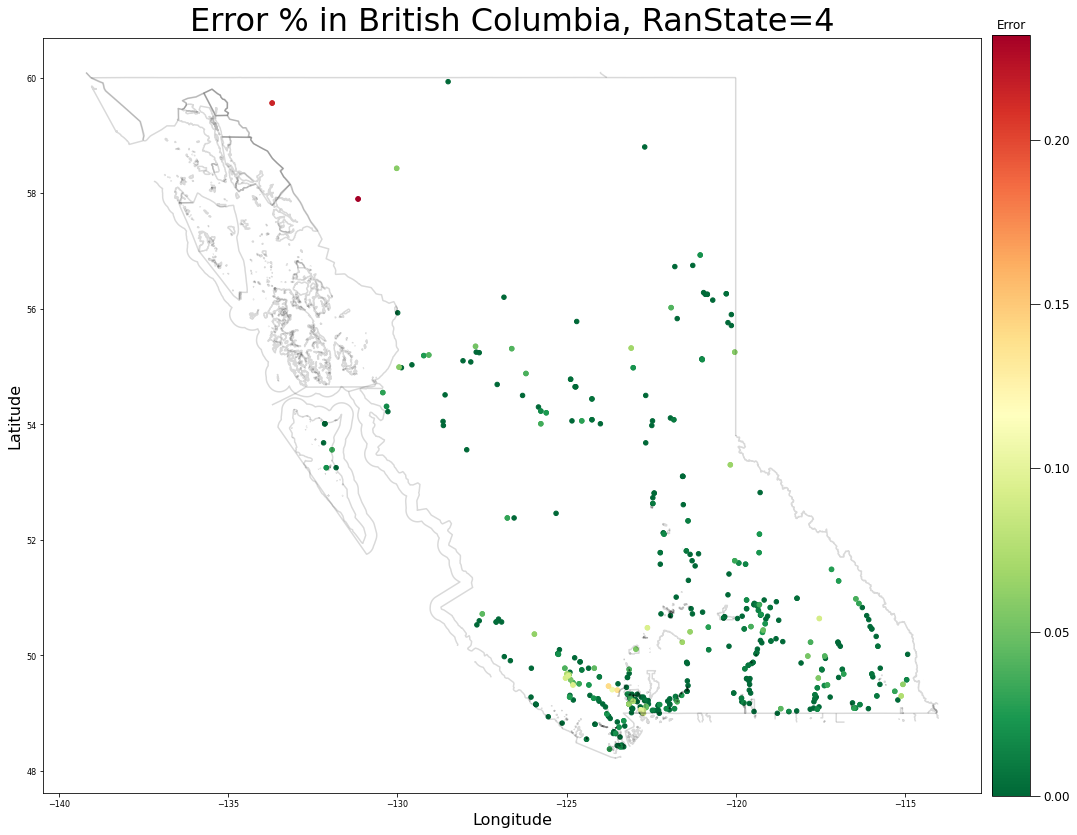

In [13]:
map = gpd.read_file("Shapefile/british_columbia_administrative.shp")
fig, ax = plt.subplots(figsize=(20, 20))
crs = CRS("EPSG:4326")

geometry = [Point(xy) for xy in (zip(mapdata["Longitude"], mapdata["Latitude"]))]
geoframe = gpd.GeoDataFrame(mapdata, crs=crs, geometry=geometry)

graph = map.plot(ax=ax, alpha=0.15, color="black")
plt.title("Error % in British Columbia, RanState=4", fontsize=32)
plt.xlabel("Longitude", fontsize=16)
plt.ylabel("Latitude", fontsize=16)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)


test = geoframe.plot(ax=ax, markersize=20, cmap="RdYlGn_r", column="Error", legend=True, legend_kwds={"shrink": 0.7, "pad": 0.01})

testfig = test.figure
testax = testfig.axes[1]
testax.tick_params(labelsize=12, length=10)
testax.set_title("Error")



In [ ]:
graph = pd.DataFrame(feats_eval["Latitude"])
graph.insert(1, "Error", errors)
graph = graph.sort_values(by=["Latitude"])

plt.scatter(graph["Latitude"], graph["Error"], s=10)
plt.title("Error % vs. Latitude")

In [ ]:
plt.hist(graph["Latitude"], bins=50)

# BC Split in Half by Latitude

In [4]:
df_mod = df.sort_values(by=["Latitude"])

divider = 3

df_train = df_mod.iloc[0: math.floor(df.shape[0] / divider)]
df_eval = df_mod.iloc[(math.floor(df.shape[0] / divider)): df.shape[0]]

In [5]:
feats_train = df_train[["Latitude", "Longitude",
                        "Total Capacity (MW)", "Annual"]]
trainfeatlist = [list(row) for row in feats_train.values]
labels_train = df_train[["First Yr Annual (MWh)"]]
trainlabellist = [list(row) for row in labels_train.values]


feats_eval = df_eval[["Latitude", "Longitude",
                      "Total Capacity (MW)", "Annual"]]
evalfeatlist = [list(row) for row in feats_eval.values]
labels_eval = df_eval[["First Yr Annual (MWh)"]]
evallabellist = [list(row) for row in labels_eval.values]


In [6]:
model = KNeighborsRegressor()
knn_grid = {"n_neighbors": np.arange(1, 21)}
model_knn = GridSearchCV(model, knn_grid, cv=9)
model_knn.fit(trainfeatlist, trainlabellist)

print("Best K Value: ", model_knn.best_params_)
print("R^2 - Fit: ", model_knn.best_score_, "\n")



Best K Value:  {'n_neighbors': 4}
R^2 - Fit:  0.7505449718846434 



In [ ]:
print(pd.DataFrame(model_knn.cv_results_))


In [7]:
output = model_knn.predict(evalfeatlist)
print("R^2 - Evaluation: ", model_knn.score(evalfeatlist, evallabellist))


R^2 - Evaluation:  -0.03025026675318565


In [8]:
errors = []

for i in range(len(output)):
    errors.append(mean_absolute_error(evallabellist[i], output[i]))

errors = pd.DataFrame(errors)


In [9]:
mapdata = df_eval[["Latitude", "Longitude", "First Yr Annual (MWh)"]]

In [10]:
mapdata.insert(3, "Error", errors)

mapdata = mapdata.sort_values(by=["Error"])

Text(0.5, 1.0, 'Error')

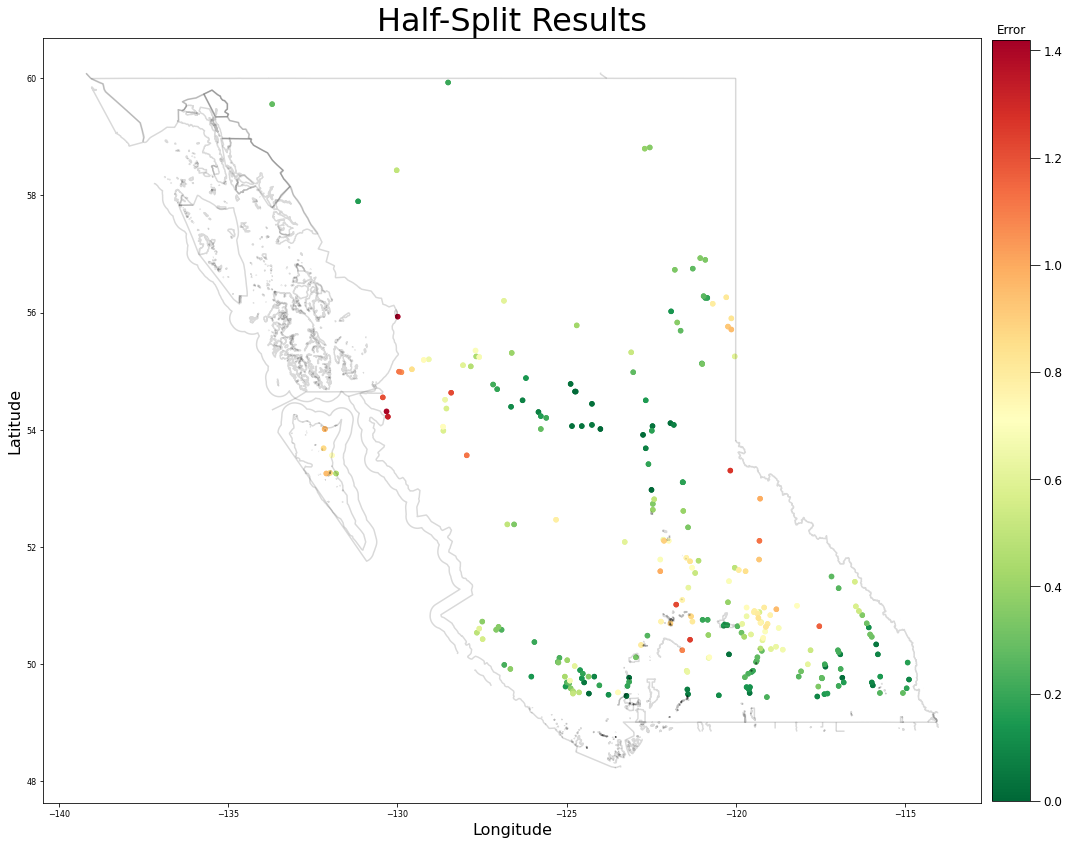

In [11]:
map = gpd.read_file("Shapefile/british_columbia_administrative.shp")
fig, ax = plt.subplots(figsize=(20, 20))
crs = CRS("EPSG:4326")

geometry = [Point(xy) for xy in (zip(mapdata["Longitude"], mapdata["Latitude"]))]
geoframe = gpd.GeoDataFrame(mapdata, crs=crs, geometry=geometry)

graph = map.plot(ax=ax, alpha=0.15, color="black")
plt.title("Half-Split Results", fontsize=32)
plt.xlabel("Longitude", fontsize=16)
plt.ylabel("Latitude", fontsize=16)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)


test = geoframe.plot(ax=ax, markersize=20, cmap="RdYlGn_r", column="Error", legend=True, legend_kwds={"shrink": 0.7, "pad": 0.01})

testfig = test.figure
testax = testfig.axes[1]
testax.tick_params(labelsize=12, length=10)
testax.set_title("Error")


In [ ]:
graph = pd.DataFrame(df_eval["Latitude"])
graph.insert(1, "Error", errors)
graph = graph.sort_values(by=["Latitude"])

plt.scatter(graph["Latitude"], graph["Error"])
plt.title("Error % vs. Latitude")

In [ ]:
plt.hist(graph["Latitude"], bins=50)

# BC Split in Half by Longitude

In [ ]:
df = df.sort_values(by=["Longitude"])


In [ ]:
print(df)


In [ ]:
df_train = df.iloc[0: math.floor(df.shape[0]/2)]
df_eval = df.iloc[math.floor(df.shape[0]/2): df.shape[0]]


In [ ]:
print(df_train)

In [ ]:
print(df_eval)

In [ ]:
feats_train = df_train[["Latitude", "Longitude",
                        "Total Capacity (MW)", "Annual"]]
trainfeatlist = [list(row) for row in feats_train.values]
labels_train = df_train[["First Yr Annual (MWh)"]]
trainlabellist = [list(row) for row in labels_train.values]


feats_eval = df_eval[["Latitude", "Longitude",
                      "Total Capacity (MW)", "Annual"]]
evalfeatlist = [list(row) for row in feats_eval.values]
labels_eval = df_eval[["First Yr Annual (MWh)"]]
evallabellist = [list(row) for row in labels_eval.values]


In [ ]:
model = KNeighborsRegressor()
knn_grid = {"n_neighbors": np.arange(1, 20)}
model_knn = GridSearchCV(model, knn_grid, cv=10)
model_knn.fit(trainfeatlist, trainlabellist)

print("Best K Value: ", model_knn.best_params_)
print("R^2 - Training: ", model_knn.best_score_, "\n")


In [ ]:
print(pd.DataFrame(model_knn.cv_results_))


In [ ]:
output = model_knn.predict(evalfeatlist)
print("R^2 - Evaluation: ", model_knn.score(evalfeatlist, evallabellist))


In [ ]:
print(mean_absolute_error(evallabellist, output))


# Mapping Points in BC

In [ ]:
print(geoframe)